In [1]:
%autosave 100

Autosaving every 100 seconds


In [80]:
import numpy as np
import numpy.linalg as npl
import math
import numdifftools as nd
import matplotlib.pyplot as plt

In [3]:
DELTA = 0.01
P_g = dict([('AlCl', 0),('AlCl2', 0),('AlCl3', 0),('H2', 0),('HCl', 10000),('N2', 90000)])
NAMES = ['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2', 'Al', 'Ga', 'AlN', 'GaN']
R = 8.314

h   = dict(zip(NAMES, [-51032., -259000., -584100., -70553., -241238., -431573., -45940., 0., -92310., 0., 0., 0., -319000., -114000.]))
fi1 = dict(zip(NAMES, [318.9948, 427.2137, 511.8114, 332.2718, 443.2976, 526.8113, 231.1183, 205.5368, 243.9878, 242.8156, 172.8289, 125.9597, 123.1132, 160.2647]))
fi2 = dict(zip(NAMES, [36.94626, 56.56409, 81.15042, 37.11052, 57.745845, 82.03355, 20.52222, 29.50487, 23.15984, 21.47467, 50.51806, 26.03107, 44.98092, 52.86351]))
fi3 = dict(zip(NAMES, [-0.001226431, -0.002961273, -0.004834879, -0.000746187, -0.002265112, -0.003486473, 0.000716251, 0.000168424, 0.001819985, 0.001748786, -0.00411847, 0.001178297, -0.00734504, -0.00799055]))
fi4 = dict(zip(NAMES, [1.1881743, 1.893842, 2.752097, 1.1606512, 1.8755545, 2.6855923, 0.7677236, 0.86065612, 0.6147384, 0.5910039, 1.476107, 0.13976, 1.86107, 2.113389]))
fi5 = dict(zip(NAMES, [5.638541, 12.40072, 13.40078, 4.891346, 3.66186, 8.278878, 244.6296, -14.95312, 51.16604, 81.08497, -458.1279, -0.5698425, 31.39626, 1.313428]))
fi6 = dict(zip(NAMES, [-5.066135, -22.65441, -21.28001, -4.467591, -9.356338, -14.5678, -251.69, 78.18955, -36.89502, -103.6265, 2105.75, 0.04723008, -49.92139, -2.441129]))
fi7 = dict(zip(NAMES, [5.219347, 21.29898, 16.92868, 5.506236, 15.88245, 12.8899, 146.6947, -82.78981, 9.174252, 71.30775, -4168.337, 7.212525, 81.22038, 1.945731]))
mu  = dict(zip(NAMES, [62.4345, 97.8875, 133.3405, 105.173, 140.626, 176.080, 17.031, 2.016, 36.461, 28.0135, 26.9815, 69.723, 40.988, 83.730]))
sigma = dict(zip(['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'], [3.58, 5.3, 5.13, 3.696, 4.293, 5.034, 3.0, 2.93, 2.737, 3.798]))
eps   = dict(zip(['AlCl', 'AlCl2', 'AlCl3', 'GaCl', 'GaCl2', 'GaCl3', 'NH3', 'H2', 'HCl', 'N2'], [932., 825., 472., 348.2, 465., 548.24, 300., 34.1, 167.1, 71.4]))
ro = dict(zip(['Al', 'Ga', 'AlN', 'GaN'], [2690, 5900, 3200, 6150]))

In [4]:
def Hi(T):
    return T / math.pow(10, 4)

def Fi_elem(elem, T):
    return fi1[elem] + fi2[elem] * np.log(Hi(T)) + fi3[elem] / math.pow(Hi(T), 2) + fi4[elem] / Hi(T) + \
           fi5[elem] * Hi(T) + fi6[elem] * (Hi(T)**2) + fi7[elem] * (Hi(T)**3)                
def G_elem(elem, T):
    return h[elem] - Fi_elem(elem, T) * T

In [5]:
def K1(T):
    return math.exp((2 * G_elem('AlCl', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - 2 * G_elem('Al', T)) / (R * T)) / (10**5)
    
def K2(T):
    return math.exp((G_elem('AlCl2', T) + G_elem('H2', T) - 2 * G_elem('HCl', T) - G_elem('Al', T)) / (R * T))
    
def K3(T):
    return math.exp((2 * G_elem('AlCl3', T) + 3 * G_elem('H2', T) - 6 * G_elem('HCl', T) - 2 * G_elem('Al', T)) / (R * T)) * (10**5)

In [6]:
def Sigma_elemN2(elem):
    return (sigma[elem] + sigma['N2']) / 2

def Eps_elemN2(elem):
    return (eps[elem] * eps['N2'])**(1/2)

def Mu_elemN2(elem):
    return 2 * mu[elem] * mu['N2'] / (mu[elem] + mu['N2'])

def Sigma1_1(x):
    return 1.074 * (x ** (-0.1604))

def D_elem(elem, T):
    return 0.02628 * (T**(3/2)) / ((10**5) * Sigma_elemN2(elem) * Sigma1_1(T / Eps_elemN2(elem)) * (Mu_elemN2(elem)**(1/2)))

In [60]:
def f0(x, T):
    return (x[0]**2) - K1(T) * x[1] * (x[2]**2)

def f1(x, T):
    return (x[0]**2) - K2(T)  * x[1] * x[3]

def f2(x, T):
    return (x[0]**6) - K3(T)  * (x[1]**3) * (x[4]**2)

def f3(x, T):
    return x[0] + 2 * D_elem('H2', T) / D_elem('HCl', T) * x[1] - (10**4)

def f4(x, T):
    return x[0] + D_elem('AlCl', T) / D_elem('HCl', T) * x[2] + 2 * D_elem('AlCl2', T) / D_elem('HCl', T) * x[3] + \
           3 * D_elem('AlCl3', T) / D_elem('HCl', T) * x[4] - (10**4)

def f(x, T):
    return np.array([f0(x, T),f1(x, T),f2(x, T),f3(x, T),f4(x, T)])

In [103]:
def newton(f, T, eps=1e-3, max_iter=int(1e9)):
    x_ = np.array([1, 2, 3, 4, 5])
    norm = 1
    iters = 0
    while norm > eps and iters < max_iter:
        a = nd.Jacobian(f)
        b = a(x_, T)
        c = npl.inv(b)
        x = x_ - c @ f(x_, T)
        norm = npl.norm(x - x_)
        x_ = x
        iters += 1
    
#    if (iters >= max_iter):
#        print('Превышено максимальное число итераций. Текущая норма:', norm)
#    else:
#        print('Итераций:', iters)
    
#    print('Проверка f(x, T) = 0 :', np.allclose(f(x, T), [0, 0, 0, 0, 0]))
    return x

In [100]:
def G(elem, P_e, T):
    return D_elem(elem, T) * (P_g[elem] - P_e[elem]) / (8314 * T * DELTA)

def V_al(P_e, T):
    return (G('AlCl', P_e, T) + G('AlCl2', P_e, T) + G('AlCl3', P_e, T)) * (mu['Al'] / ro['Al']) * (10**9)

P_e = dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, 800)))
print(G('AlCl', P_e, 800))
print(G('AlCl2', P_e, 800))
print(G('AlCl3', P_e, 800))
print(V_al(P_e, 800))

Итераций: 25
Проверка f(x, T) = 0 : True
-1.46960065977e-08
-5.74370971132e-10
-2.07584593002e-05
-208.366686728


In [102]:
KELVIN = 273
x = np.linspace(350 + KELVIN, 650 + KELVIN, 10)
y = [dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, t))) for t in x]

Итераций: 46
Проверка f(x, T) = 0 : True
Итераций: 42
Проверка f(x, T) = 0 : True
Итераций: 37
Проверка f(x, T) = 0 : True
Итераций: 33
Проверка f(x, T) = 0 : True
Итераций: 29
Проверка f(x, T) = 0 : True
Итераций: 26
Проверка f(x, T) = 0 : True
Итераций: 24
Проверка f(x, T) = 0 : True
Итераций: 23
Проверка f(x, T) = 0 : True
Итераций: 23
Проверка f(x, T) = 0 : True
Итераций: 39
Проверка f(x, T) = 0 : True


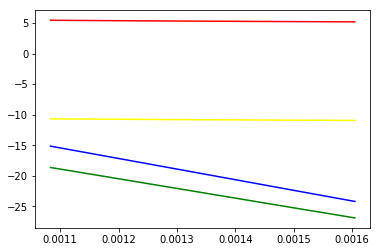

In [104]:
y1 = [G('AlCl', dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, t))), t) for t in x]
y2 = [G('AlCl2', dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, t))), t) for t in x]
y3 = [G('AlCl3', dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, t))), t) for t in x]
y4 = [V_al(dict(zip(['HCl', 'H2', 'AlCl', 'AlCl2', 'AlCl3'], newton(f, t))), t) for t in x]

fig, ax = plt.subplots()
ax.plot(np.divide(np.array([1 for i in x]), x), np.log(np.fabs(y1)), color="blue")
ax.plot(np.divide(np.array([1 for i in x]), x), np.log(np.fabs(y2)), color="green")
ax.plot(np.divide(np.array([1 for i in x]), x), np.log(np.fabs(y3)), color="yellow")
ax.plot(np.divide(np.array([1 for i in x]), x), np.log(np.fabs(y4)), color="red")
plt.show()

In [7]:
print(K1(500))
print(D_elem('AlCl', 600))

3.3823032102250726e-05
0.0001794855492744165


In [8]:
print(P_g)
for key in P_g:
    print(key, P_g[key])

{'AlCl': 0, 'AlCl2': 0, 'AlCl3': 0, 'H2': 0, 'HCl': 10000, 'N2': 90000}
AlCl 0
AlCl2 0
AlCl3 0
H2 0
HCl 10000
N2 90000


In [9]:
print(P_g['HCl'])

10000


In [10]:
d1 = dict([(('AlCl', 1), 0),(('AlCl', 2), 1000)])
print(d1[('AlCl', 1)])
for key in d1:
    print(key, d1[key])

0
('AlCl', 1) 0
('AlCl', 2) 1000
